In [1]:
!pip install aicrowd-cli==0.1
API_KEY = "4c49d255257272f8caf90b1e74b8cccd"
!aicrowd login --api-key $API_KEY

API Key valid
Saved API Key successfully!


In [2]:
import pathlib
import tensorflow as tf

In [3]:
import pandas as pd
import os

In [4]:
!ls

00_subs.csv  sample_submission.csv  train      val
sample_data  test		    train.csv  val.csv


In [5]:
data_folder = ""

In [6]:
df_train = pd.read_csv(os.path.join(data_folder, "train.csv"))

In [7]:
df_val = pd.read_csv(os.path.join(data_folder, "val.csv"))

In [8]:
df_train['ImageID'] = df_train['ImageID'].astype(str)+".jpg"
df_val['ImageID'] = df_val['ImageID'].astype(str)+".jpg"

In [9]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Conv2D, Flatten, Dropout, MaxPooling2D, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import regularizers, optimizers
import os
import numpy as np
import pandas as pd

In [11]:
class CustomAugment(object):
    def __call__(self, image):        
        # Random flips and grayscale with some stochasticity
        img = self._random_apply(tf.image.flip_left_right, image, p=0.5)
        img = self._random_apply(self._color_drop, img, p=0.8)
        return img

    def _color_drop(self, x):
        image = tf.image.rgb_to_grayscale(x)
        image = tf.tile(x, [1, 1, 1, 3])
        return x
    
    def _random_apply(self, func, x, p):
        return tf.cond(
          tf.less(tf.random.uniform([], minval=0, maxval=1, dtype=tf.float32),
                  tf.cast(p, tf.float32)),
          lambda: func(x),
          lambda: x)

In [12]:
data_augmentation = tf.keras.Sequential(
  [
    tf.keras.layers.Lambda(CustomAugment()),
    tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(256, 
                                                              256,
                                                              3)),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.1),
    tf.keras.layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

In [13]:
model = Sequential()
model.add(data_augmentation)
model.add(Conv2D(32, (3, 3), padding='same',
                 input_shape=(256,256,3)))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))

model.compile(optimizers.RMSprop(lr=0.0001), loss="categorical_crossentropy", metrics=["Recall", "Precision", "categorical_crossentropy"])

In [14]:
datagen=ImageDataGenerator(rescale=1./255.)

train_generator=datagen.flow_from_dataframe(
dataframe=df_train,
directory="train/",
x_col="ImageID",
y_col="label",
batch_size=64,
seed=42,
shuffle=True,
class_mode="categorical",
target_size=(256,256))

val_generator=datagen.flow_from_dataframe(
dataframe=df_val,
directory="val/",
x_col="ImageID",
y_col="label",
batch_size=64,
seed=42,
shuffle=True,
class_mode="categorical",
target_size=(256,256))

Found 40000 validated image filenames belonging to 2 classes.
Found 4000 validated image filenames belonging to 2 classes.


In [15]:
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VAL=val_generator.n//train_generator.batch_size

In [16]:
model.fit(train_generator, steps_per_epoch=STEP_SIZE_TRAIN, 
          validation_data=val_generator, validation_steps=STEP_SIZE_VAL, epochs=1)

625/625 [==============================] - 109s 170ms/step - loss: 0.7249 - recall: 0.6390 - precision: 0.6390 - categorical_crossentropy: 0.7249 - val_loss: 0.3153 - val_recall: 0.8642 - val_precision: 0.8642 - val_categorical_crossentropy: 0.3153


In [17]:
df_test = pd.read_csv("sample_submission.csv", dtype=str)
df_test["ImageID"] = df_test["ImageID"].astype(str)+".jpg"

In [18]:
test_generator=datagen.flow_from_dataframe(
dataframe=df_test,
directory="test/",
x_col="ImageID",
y_col="label",
batch_size=1,
shuffle=False,
target_size=(256,256))

Found 10000 validated image filenames belonging to 2 classes.


In [19]:
STEP_SIZE_TEST = test_generator.n//test_generator.batch_size

In [20]:
STEP_SIZE_TEST

10000

In [21]:
test_generator.reset()
pred = model.predict(test_generator,
steps=STEP_SIZE_TEST,
verbose=1)

10000/10000 [==============================] - 47s 5ms/step


In [22]:
len(pred)

10000

In [23]:
predicted_class_indices = np.argmax(pred,axis=1)

In [24]:
labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in predicted_class_indices]

In [25]:
len(predictions)

10000

In [26]:
df_test["pred"] = predictions

In [27]:
df_test.head()

,ImageID,label,pred
0,0.jpg,curiosity,curiosity
1,1.jpg,perseverance,curiosity
2,2.jpg,curiosity,curiosity
3,3.jpg,perseverance,perseverance
4,4.jpg,perseverance,curiosity


In [28]:
df_test.drop("label", axis=1, inplace=True)
df_test.rename(columns={"pred": "label"}, inplace=True)

In [29]:
df_test.head()

,ImageID,label
0,0.jpg,curiosity
1,1.jpg,curiosity
2,2.jpg,curiosity
3,3.jpg,perseverance
4,4.jpg,curiosity


In [30]:
df_test.to_csv("00_subs.csv",index=False)

In [31]:
TEST_DIR = "test/"

In [32]:
train_generator.class_indices

{'curiosity': 0, 'perseverance': 1}

In [33]:
import matplotlib.pyplot as plt

In [34]:
%matplotlib inline
import cv2

In [35]:
df_test.head(15)

,ImageID,label
0,0.jpg,curiosity
1,1.jpg,curiosity
2,2.jpg,curiosity
3,3.jpg,perseverance
4,4.jpg,curiosity
5,5.jpg,curiosity
6,6.jpg,curiosity
7,7.jpg,curiosity
8,8.jpg,perseverance
9,9.jpg,perseverance


In [36]:
predicted_class_indices

array([0, 0, 0, ..., 0, 0, 0])

In [37]:
from PIL import Image
import numpy as np
from skimage import transform
def load(filename):
   np_image = Image.open(filename)
   np_image = np.array(np_image).astype('float32')/255
   np_image = transform.resize(np_image, (256, 256, 3))
   np_image = np.expand_dims(np_image, axis=0)
   return np_image

image = load('test/9.jpg')
model.predict(image)

array([[0.17762142, 0.82237864]], dtype=float32)

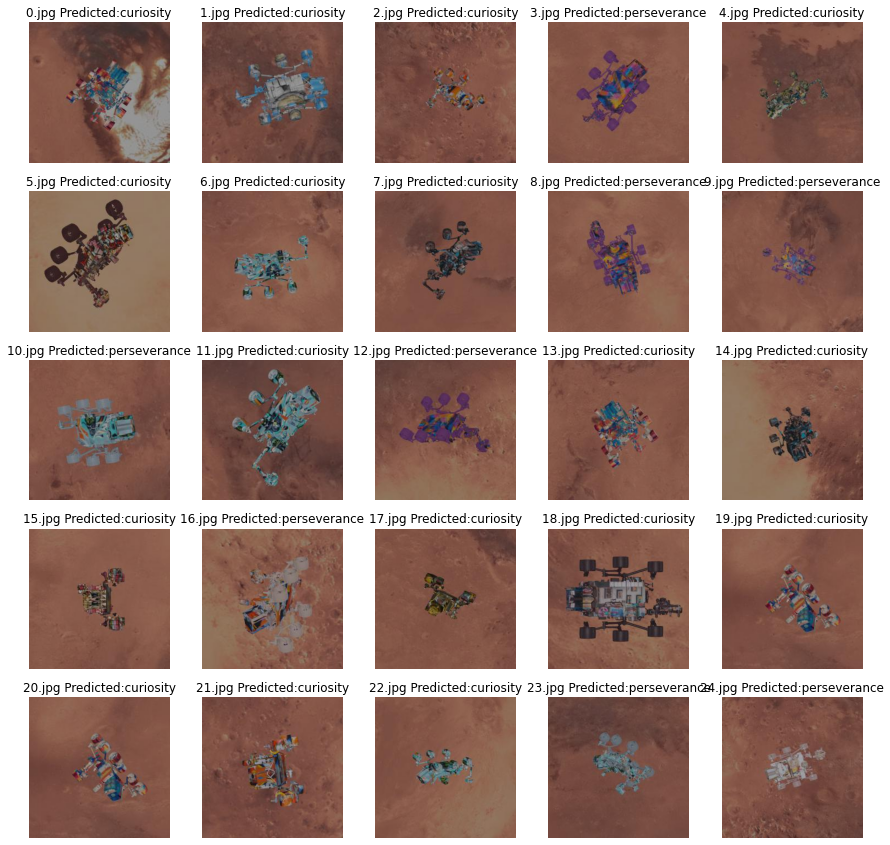

In [38]:
f, ax = plt.subplots(5, 5, figsize = (15, 15))

for i in range(0,25):
    test_generator.filenames
    imgBGR = cv2.imread(TEST_DIR + test_generator.filenames[i])
    imgRGB = cv2.cvtColor(imgBGR, cv2.COLOR_BGR2RGB)
    
    # a if condition else b
    predicted_class = "perseverance" if predicted_class_indices[i] else "curiosity"

    ax[i//5, i%5].imshow(imgRGB)
    ax[i//5, i%5].axis('off')
    ax[i//5, i%5].set_title(test_generator.filenames[i] + " " + "Predicted:{}".format(predicted_class))    

plt.show()

In [39]:
!aicrowd submission create -c rover-classification -f 00_subs.csv

00_subs.csv ━━━━━━━━━━━━━━━━━━━━━━━ 100.0% • 202.6/200.9 KB • 3.5 MB/s • 0:00:00
                                    ╭─────────────────────────╮                                     
                                    │ Successfully submitted! │                                     
                                    ╰─────────────────────────╯                                     
                                          Important links                                           
┌──────────────────┬───────────────────────────────────────────────────────────────────────────────┐
│  This submission │ https://www.aicrowd.com/challenges/ai-blitz-7/submissions/126483              │
│                  │                                                                               │
│  All submissions │ https://www.aicrowd.com/challenges/ai-blitz-7/submissions?my_submissions=true │
│                  │                                                                               │
│      Lea